In [12]:
import pandas as pd

data = pd.read_csv("data/synth_data_for_training.csv")
print(data.shape)
print(data.info())
print(data.describe(include='all'))


(12645, 316)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Columns: 316 entries, adres_aantal_brp_adres to checked
dtypes: int64(316)
memory usage: 30.5 MB
None
       adres_aantal_brp_adres  adres_aantal_verschillende_wijken  \
count            12645.000000                       12645.000000   
mean                 2.878529                           2.101621   
std                  1.457492                           0.934861   
min                  1.000000                           1.000000   
25%                  2.000000                           1.000000   
50%                  3.000000                           2.000000   
75%                  4.000000                           3.000000   
max                 11.000000                           7.000000   

       adres_aantal_verzendadres  adres_aantal_woonadres_handmatig  \
count               12645.000000                      12645.000000   
mean                    0.433294                        

In [10]:
sensitive_cols = ['persoon_geslacht_vrouw', 'persoon_leeftijd_bij_onderzoek']
for col in sensitive_cols:
    print(f"{col} distribution:\n", data[col].value_counts())


persoon_geslacht_vrouw distribution:
 persoon_geslacht_vrouw
0    6542
1    6103
Name: count, dtype: int64
persoon_leeftijd_bij_onderzoek distribution:
 persoon_leeftijd_bij_onderzoek
51    493
52    491
53    474
48    473
55    466
50    460
54    438
49    434
58    428
57    427
47    411
46    406
56    404
45    401
44    389
59    372
61    365
60    365
43    361
42    353
62    339
63    315
40    305
41    296
39    273
64    265
65    258
38    228
37    217
36    212
66    192
35    185
34    149
33    128
32    115
31    111
30     93
29     91
28     86
67     80
27     63
26     50
25     44
24     43
23     32
22     24
21     18
19     11
20     11
Name: count, dtype: int64


<Axes: >

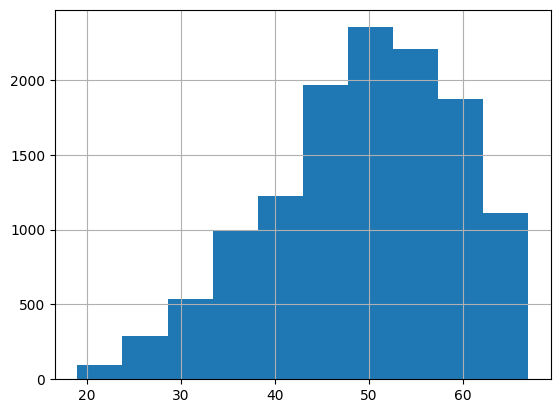

In [11]:
data['persoon_leeftijd_bij_onderzoek'].hist() # age of the person

#### Description of the data

Main fatcs:
- Dataset has 316 variables
- Almost all variables are integers (0/1 flags or counts)

Sensitive columns present include
- persoon_geslacht_vrouw (gender)
- persoon_leeftijd_bij_onderzoek (age)

Ethnicity/nationality variables were removed, but many proxies remain.

### Data analysis and problems with data

#### First problem: Proxy variable for protected attributes

Sensitive attributed are removed from the data because they are legally protected under Dutch anti-discrimination law. Those attributes include:
- Ethnicity / migration background
- Nationality
- Country of birth
- Parents’ country of birth
- Religion
- Neighborhood “ethnic concentration” flags
- Language spoken
- Asylum seeker status
- Detailed immigration reason / status

However they can be derived from other attributes.
For example, attributes for neighbourhood such as:
- adres_recentste_buurt_nieuwe_westen
- adres_recentste_buurt_groot_ijsselmonde
- adres_recentste_buurt_oude_noorden
- adres_recentste_buurt_other 
might act as ethnicity proxies, even though ethnicity itself is removed because Rotterdam neighborhoods strongly correlate with average income, proportion of residents with a migration background, and poverty concentration.

Also, language variables, which can be proxies for ethnicity and race, make up a significant number of the total variables.

This is a data validity issue.

#### Second problem: Sensitive attributes influence predictions too much

Although explicit ethnicity attributes were removed, gender and age remain in the dataset, and many other variables encode family structure (e.g., relatie_kind_volwassen). These attributes can systematically influence the fraud-risk prediction, even though they have no meaningful or causal relationship to welfare fraud.

In practice, this means that certain groups, such as women, especially women with children, may be assigned higher risk scores simply because of their demographic characteristics. This reflects bias in the prediction model, as the presence of these attributes allows the algorithm to treat similar cases differently based on gender or age rather than relevant behavioral indicators.


#### Third problem: Many variables have no meaningful or causal relationship to welfare fraud 

The dataset contains a very large number of administrative flags and neighborhood statistics, such as:
- number of past addresses
- changes in living arrangements
- obstacle_living_situation
These variables do not represent actual fraud behavior. Instead, they reflect poverty, instability in life circumstances, needing social support. This means the model predicts who is poor or struggling, but not who is actually committing fraud.

This is another data validity issue.

#### Fourth issue: Data is skewed/inbalanced

The age distribution shows a clear imbalance (histogram presented before). The vast majority of individuals in the dataset are over 40, while younger people are heavily underrepresented. For example, ages 50–60 each appear around 400–500 times, whereas ages under 30 often occur fewer than 100 times.

This means the dataset is skewed toward older welfare recipients, which can affect model behaviour. A model trained on this distribution will primarily learn patterns from older individuals and may perform poorly on younger people due to limited representation.




### Possible test cases

#### Data partitioning

We will create two types of partitioning. One when we expect the model to have similar results on both partitions and another when we expect to have different results on partitions.

In [ ]:
# Data partitioning

target_col = "checked" # not sure about the name

# Partition 1: Expect SAME results

# Split by gender: male vs female (assuming model should not behave differently based on gender)
partition_same_1 = data[data['persoon_geslacht_vrouw'] == 1]
partition_same_2 = data[data['persoon_geslacht_vrouw'] == 0]

# Partition 2: Expect DIFFERENT results

# Split by history of addictions (but I don't know if it's a good criteria for results to be different)
partition_diff_1 = data[data['belemmering_hist_verslavingsproblematiek'] == 1]
partition_diff_2 = data[data['belemmering_hist_verslavingsproblematiek'] == 0]

def test_model_on_partitions(model, partitions, target_col=target_col):
    results = {}
    for i, part in enumerate(partitions):
        X = part.drop(columns=[target_col])
        y = part[target_col]
        preds = model.predict(X)
        results[f"partition_{i+1}"] = {
            "size": len(part),
            "accuracy": (preds == y).mean()
        }
    return results


# Example usage:

# model.fit(data.drop(columns=[target_col]), data[target_col])
# same_results = test_model_on_partitions(model, [partition_same_1, partition_same_2])
# diff_results = test_model_on_partitions(model, [partition_diff_1, partition_diff_2])



In [ ]:
# Metamorphic test cases

# Results should not depend on the gender
def metamorphic_gender_swap(model, data, target_col='checked'):
    data_copy = data.copy()
    data_copy['persoon_geslacht_vrouw'] = 1 - data_copy['persoon_geslacht_vrouw']
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    return preds_new


# Small changes in age should not make any difference
def metamorphic_age_shift(model, data, target_col='checked', shift=1):
    data_copy = data.copy()
    data_copy['persoon_leeftijd_bij_onderzoek'] += shift
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    return preds_new


# Swapping districts should not change result (probably, I am not sure about it)
def metamorphic_swap_districts(model, data, target_col='checked'):
    """
    Swap Delfshaven and Feijenoord district indicators.
    """
    data_copy = data.copy()
    
    delf = 'adres_recentste_wijk_delfshaven'  # address_latest_district_delfshaven
    feij = 'adres_recentste_wijk_feijenoord'  # address_latest_district_feijenoord
    
    temp = data_copy[delf].copy()
    data_copy[delf] = data_copy[feij]
    data_copy[feij] = temp
    
    X = data_copy.drop(columns=[target_col])
    preds_new = model.predict(X)
    
    # Compare with original predictions
    # X_orig = data.drop(columns=[target_col])
    # preds_orig = model.predict(X_orig)
    # n_changed = (preds_new != preds_orig).sum()
    # pct_changed = n_changed / len(data) * 100
    # print(f"{n_changed} predictions changed ({pct_changed:.2f}%) after swapping districts")

    return preds_new

